In [0]:
!pip install twitter

     |████████████████████████████████| 61kB 2.0MB/s 


In [0]:
import json
import pandas as pd
from twitter import *
from numpy import random

In [0]:
with open('auth_dict','r') as f:
    twtr_auth = json.load(f)

t = Twitter(auth=OAuth(twtr_auth['token'], twtr_auth['token_secret'], 
            twtr_auth['consumer_key'], twtr_auth['consumer_secret']))

In [0]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e


    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [0]:
from functools import partial
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=5000)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: 
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            if len(ids) >= limit or response is None:
                break
    return friends_ids[:friends_limit], followers_ids[:followers_limit]


In [0]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    assert (screen_names != None) != (user_ids != None), \
        "Must have screen_names or user_ids, but not both"
    items_to_info = {}
    items = screen_names or user_ids
    sorted_by_follow_count = []
    while len(items) > 0:
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, screen_name=items_str)
        else: 
            response = make_twitter_request(twitter_api.users.lookup, user_id=items_str)
        for user_info in response:
            if screen_names:
                items_to_info[user_info['followers_count']] = user_info['screen_name']
            else: 
                items_to_info[user_info['followers_count']] = user_info['id']
        
    for key in sorted(items_to_info, reverse=True):
        sorted_by_follow_count.append(items_to_info[key])
    return sorted_by_follow_count[:5]

In [0]:
df = pd.DataFrame(columns=['ID','ReciprocalFriend'])
df.to_csv('ReciprocalFriend.csv', index=False)

def save_followers(fid, reciprocal_friend):
    data_frame_rf = [[str(fid), str(i)] for i in reciprocal_friend]
    df = pd.DataFrame(data_frame_rf, columns=['ID','ReciprocalFriend'])
    with open('ReciprocalFriend.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

In [0]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends_ids, followers_ids = get_friends_followers_ids(twitter_api, user_id=seed_id,
                                 friends_limit=limit, followers_limit=limit)
    rp_friend = list(set(friends_ids) & set(followers_ids))
    top_five = get_user_profile(t, user_ids=rp_friend[:100])
    next_queue = top_five
    
    save_followers(seed_id, next_queue)
    
    d = 1
    while d < depth:
        print("Number of ", d,"- Distance node", len(next_queue))
        d += 1
        (queue, next_queue) = (next_queue, [])
        for fid in queue:
            friends_ids, followers_ids = get_friends_followers_ids(twitter_api, user_id=fid,
                                friends_limit=limit, followers_limit=limit)
            rp_friend = list(set(friends_ids) & set(followers_ids))
            if (len(rp_friend) == 0):
                continue
            top_five = get_user_profile(t, user_ids=rp_friend[-100:])
            save_followers(str(fid), top_five)
            next_queue += top_five

In [0]:
screen_name = 'COVIDNewsByMIB'
crawl_followers(t, screen_name, depth=4, limit=5000)

In [0]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [0]:
df = pd.read_csv("ReciprocalFriend.csv")
x_point = list(df[df.columns[0]].values)
y_point = list(df[df.columns[1]].values)
edges_list = []
for i in range(len(x_point)):
    edges_list.append((x_point[i], y_point[i]))
node_list = set(x_point+y_point)
RG = nx.Graph()
RG.add_nodes_from(node_list)
RG.add_edges_from(edges_list)

In [0]:
print ("Number of Nodes :", RG.number_of_nodes())
print ("Numebr of edges :", RG.number_of_edges())

Number of Nodes : 108
Numebr of edges : 108


In [0]:
A = nx.adjacency_matrix(RG)
D = np.diag(list(dict(nx.degree(RG)).values()))
E = RG.get_edge_data
L = D - A

for i in range(len(edges_list)):
    print(edges_list[i])

(2384071, 28049003.0)
(2384071, 33039483.0)
(2384071, 304587968.0)
(2384071, 236485849.0)
(2384071, 1339518313.0)
(28049003, 2596143056.0)
(28049003, 1480749782.0)
(33039483, 17995040.0)
(33039483, 33041426.0)
(33039483, 41814169.0)
(33039483, 8.75029068223316e+17)
(33039483, 2835276183.0)
(304587968, 2384071.0)
(304587968, 5943622.0)
(304587968, 165944767.0)
(304587968, 19383099.0)
(304587968, 42336153.0)
(236485849, 14763734.0)
(236485849, 190906140.0)
(236485849, 2461810448.0)
(236485849, 246939630.0)
(236485849, 32780218.0)
(1339518313, 19691332.0)
(1339518313, 53560219.0)
(1339518313, 18419094.0)
(1339518313, 125695429.0)
(1339518313, 1237502864.0)
(2596143056, 2573480784.0)
(2596143056, 2729061.0)
(2596143056, 769641584.0)
(2596143056, 65937068.0)
(2596143056, 22485748.0)
(1480749782, 90573676.0)
(1480749782, 28049003.0)
(1480749782, 2451476942.0)
(1480749782, 44317593.0)
(1480749782, 1552045182.0)
(2835276183, 1.16021125015379e+18)
(2384071, 28049003.0)
(2384071, 33039483.0)
(23

In [0]:
lmbds,vctrs= np.linalg.eig(L)
indx = [i for i in range(len(lmbds)) if lmbds[i] > .01 and lmbds[i] < .06]

for i in range(len(lmbds)):
  if lmbds[i] > .01 and lmbds[i] < .06:
    print("Size of community: ", i)
    print("Leading ID of community: ", edges_list[i][0])
    print("\n")

RG_mbd = vctrs.real[:,indx]
print ("We will divide our Graph in", len(indx), "communities")


Size of community:  25
Leading ID of community:  1339518313


Size of community:  26
Leading ID of community:  1339518313


Size of community:  30
Leading ID of community:  2596143056


We will divide our Graph in 3 communities


In [0]:
est = KMeans(n_clusters=len(indx))
est.fit(RG_mbd)

labels = est.labels_

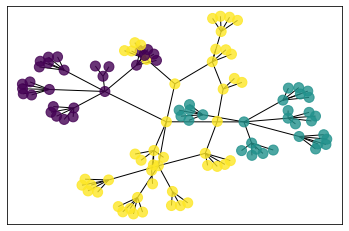

In [0]:
pos = nx.spring_layout(RG)
nx.draw_networkx_nodes(RG,pos,
                       nodelist=node_list,
                       node_color=labels,
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_edges(RG,pos)
plt.show()